# Investigate A Dataset: Titanic Data Analysis


### Introduction

The purpose of this project is to perform analysis on a dataset containing demographic and passenger information of the RMS Titanic and to find likely factors that affect a passenger's chance in surviving the sinking ship. More information regarding the dataset can be found at https://www.kaggle.com/c/titanic.

#### Data Dictionary

Taken from https://www.kaggle.com/c/titanic/data.


Variable      | Definition                                | Key
------------- | ------------------------------------------|------------------------------------------------
survival      | Survival                                  | 0 = No, 1 = Yes
pclass        | Ticket Class                              | 1 = 1st, 2 = 2nd, 3 = 3rd
sex           | Sex                                       |
Age           | Age in years                              |
sibsp         | # of siblings/spouses aboard the Titanic  |
parch         | # of parents/children aboard the Titanic  |
ticket        | Ticket number                             |
fare          | Passanger fare                            |
cabin         | Cabin number                              |
embarked      | Port of Embarkation                       | C = Cherbourg, Q = Queenstown, S = Southampton

Notes:
* pclass is aproxy for socio-economic status (SES) 
o 1st = Upper
o 2nd = Middle
o 3rd = Lower
* Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5
* sibsp defines sibling (brother, sister, stepbrother, stepsister) and spouse (husband, wife)
* parch defines parent (mother, father) and child (daughter, son, stepdaughter, stepson)
* Some children travelled only with a nanny, therefore parch=0 for them.


# Question

The main question that I want to answer is which characteristics of a Titanic passenger affect the passenger's chance of survival.  

To answer that question, I've decided to focus on few characteristics that I'll explore using questions below:
1. Did female passanger have a better chance of survival than male?
2. Did socio-economic status count as a factor in survival rate?  
3. Did traveling alone (without family members: parents, spouse, children, or siblings) give a passanger a better chance at survival?
4. Did children (18 year-old or younger) have a better chance of survival? 

# Data Wrangling

## Data Acquisition

The dataset was provided in a csv file format as part of project material.  

Now let's set up IPython Notebook by importing all necessary modules. We'll also need to set matplotlib to render plots inline for better viewing.  

In [48]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# set matplotlib to render plots inline
%matplotlib inline

Now let read the dataset and store it into a Pandas DataFrame

In [49]:
# read and store CSV dataset into pandas dataframe
titanic_df = pd.read_csv('titanic-data.csv')

Now let's see what we have.

In [50]:
# display dataframe info
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Notice that we have 891 entries in the data set and it looks like most columns have complete entries and only 3 columns have some missing values. Those columns with missing values are Age, Cabin, and Embark, with most missing values appear in Cabin. It does also look like all people in the dataset were passengers (not crew members) of the Titanic because they all paid fare and got a ticket. This is important to note because we just want to see survival chance of passengers and not of crew members. Therefore, we don't want to have crew data in our dataset that can lead to misinterpretation.

Now let's see the first and last few entries in the dataset.

In [51]:
# display first few records to review data format and value
titanic_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
# display last few records to review data format and value
titanic_df.tail(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Notice that some values are indeed missing (NaN) for Age, which can be problematic when we try to answer question # 4. Some values are also missing for Cabin, though this one won't be a problem since we wouldn't need Cabin data to answer those questions mentioned above. 

Some columns are not relevant to our questions (i.e. PassangerId, Name, Ticket, Fare, Cabin and Embarked), and we better remove them to unclutter the data. Some other columns are not direct subjects of our investigation (i.e. SibSp and Parch). We need to manipulate those columns to directly represent a variable that we want to investigate. 

To answer question # 3, we need to know whether a passanger was traveling alone (without family members) but we don't have a column showing that information. However, we can easily get it from column SibSp and Parch. If SibSp + Parch is zero, then the passanger must traveling alone. It is worth to take a note here that a stepchild as well as a stepsibling counted as family members.

Now, let's start cleaning the dataset.

## Data Cleaning

Here's what we're going to do:
1. Check for and remove duplicates.
2. Remove unnecessary columns.
3. Convert SibSp and Parch columns into Talone (traveling alone) column, remove unnecessary columns.
4. Check for incorrect and missing values, and map data values when necessary.

So let's roll.

#### 1. Removing Duplicate Entry

In [53]:
# display the number of duplicate entries
print "Number of duplicate entry = {}".format(titanic_df.duplicated().sum())

Number of duplicate entry = 0


We don't have any duplicate entry. Great, now let's move on

#### 2. Removing Unnecessary Columns

In [54]:
# create new dataframe with unnecesssary columns removed
cleaned_titanic_df = titanic_df.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin", "Embarked"], axis=1)

# view new dataframe
cleaned_titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


#### 3. Converting SibSp and Parch into Talone

What I want to do here is to have a column named Talone that has a value of either 1 (traveled alone) or 0 (not traveled alone). First I'll create a column that take a value from the sum of SibSp and Parch values. Then, I'll convert the sum to reflect that if it is 0 then the passenger was traveling alone, otherwise the passenger was not traveling alone.

In [55]:
# add a column named Talone,to reflect the number of familiy member traveling with the passenger
cleaned_titanic_df['Talone'] = cleaned_titanic_df.SibSp + cleaned_titanic_df.Parch

# display first few entries
cleaned_titanic_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Talone
0,0,3,male,22.0,1,0,1
1,1,1,female,38.0,1,0,1
2,1,3,female,26.0,0,0,0
3,1,1,female,35.0,1,0,1
4,0,3,male,35.0,0,0,0
5,0,3,male,NaN,0,0,0
6,0,1,male,54.0,0,0,0
7,0,3,male,2.0,3,1,4
8,1,3,female,27.0,0,2,2
9,1,2,female,14.0,1,0,1


I'm going to use a lambda function to convert each value of Talone into False or True. Then, check for missing and incorrect values to make sure that I've converted all values correctly.

In [56]:
# update Talone values by applying a lambda function
cleaned_titanic_df['Talone'] = cleaned_titanic_df.Talone.apply(lambda x: False if x > 0 else True)

# check whether the update produce any missing values
sum_Talone_missing = cleaned_titanic_df.Talone.isnull().sum()

# check whether the update produce any incorrect values
sum_Talone_incorrect = len(cleaned_titanic_df.Talone)-cleaned_titanic_df.Talone.isin([0,1]).sum()

print "Number of missing values for Talone column = {}".format(sum_Talone_missing)
print "Number of incorrect values for Talone column = {}".format(sum_Talone_incorrect)

Number of missing values for Talone column = 0
Number of incorrect values for Talone column = 0


Nice, we have all values correct for Talone column. Now we can remove SibSp, and Parch columns since we don't need them anymore.

In [57]:
# remove unnecessary columns
cleaned_titanic_df = cleaned_titanic_df.drop(["SibSp", "Parch"], axis=1)

# display first few entries
cleaned_titanic_df.head(n=10)

,Survived,Pclass,Sex,Age,Talone
0,0,3,male,22.0,False
1,1,1,female,38.0,False
2,1,3,female,26.0,True
3,1,1,female,35.0,False
4,0,3,male,35.0,True
5,0,3,male,NaN,True
6,0,1,male,54.0,True
7,0,3,male,2.0,False
8,1,3,female,27.0,False
9,1,2,female,14.0,False


#### 4. Checking For Incorrect and Missing Values

To save ourselves from typing repetitive codes, let's define a few helper functions

In [58]:
# draw bar graph for the input column
def cleaned_titanic_bargraph(col_name):
    """
    Args:
        col_name: column to use
    """
    # plot the bar graph
    g = cleaned_titanic_df.groupby([col_name]).size().plot(kind='bar', rot =0)
    
    # set the title
    g.axes.set_title('{} Distribution of Titanic Passanger in Dataset'.format(col_name))
    
    # set the y label
    g.axes.set_ylabel('No. of Passengers')

# display the distribution of data in a column
def cleaned_titanic_dist(col_name):
    """
    Args:
        col_name: column to use
    Returns:
        pandas dataframe consists of count and percentage of each value in the column
    """
    
    # display missing values
    print 'Number of missing values: {}'.format(cleaned_titanic_df[col_name].isnull().sum())
    
    # values count
    count = cleaned_titanic_df.groupby([col_name]).size() 
    
    # values percentage
    percentage = count.groupby(level=0).apply(lambda x: (100*x/count.sum()).round(1))
    
    # store in a panda dataframe
    df = pd.DataFrame(data={col_name:count.keys(),'count':count, 'percentage':percentage})
    
    return df.set_index(col_name)

##### Survived

Since Survived column currently takes 0 for non-survivors and 1 for survival, then we will change the value to False and True respectively, for better interpretation of data values.

In [59]:
# update Survived values to True or False
cleaned_titanic_df['Survived'] = cleaned_titanic_df.Survived.apply(lambda x: False if x == 0 else True)

Number of missing values: 0


,count,percentage
Survived,,
False,549,61.6
True,342,38.4


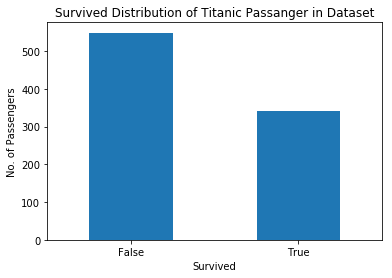

In [60]:
cleaned_titanic_bargraph('Survived')
cleaned_titanic_dist('Survived')

There's no incorrect and no missing values in Survived column. The numbers show that only 38.4% passangers in the dataset survived the tragedy.

##### Pclass

Number of missing values: 0


,count,percentage
Pclass,,
1,216,24.2
2,184,20.7
3,491,55.1


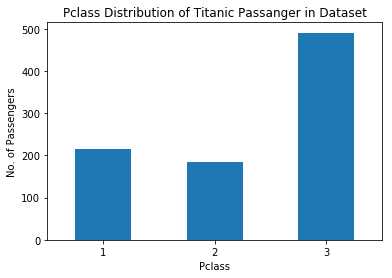

In [61]:
cleaned_titanic_bargraph('Pclass')
cleaned_titanic_dist('Pclass')

There's no incorrect and no missing values in Pclass column. The numbers show that most passengers (55.1%) in the dataset were from 3rd class.

##### Sex

Number of missing values: 0


,count,percentage
Sex,,
female,314,35.2
male,577,64.8


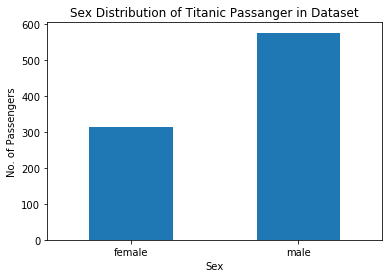

In [62]:
cleaned_titanic_bargraph('Sex')
cleaned_titanic_dist('Sex')

There's no incorrect and no missing values in Sex column. The numbers show that most passengers in the dataset (64.8%) are males, and only 35.2% of them are females.

##### Age

Since we're going to need the data grouped base on age (children and adult), then we better do it now.

In [63]:
# add a column 
cleaned_titanic_df['AgeGroup'] = cleaned_titanic_df.Age.apply(lambda x: None if pd.isnull(x) else "Child" if x <=18 else "Adult")
 
cleaned_titanic_df.head(n=10)

,Survived,Pclass,Sex,Age,Talone,AgeGroup
0,False,3,male,22.0,False,Adult
1,True,1,female,38.0,False,Adult
2,True,3,female,26.0,True,Adult
3,True,1,female,35.0,False,Adult
4,False,3,male,35.0,True,Adult
5,False,3,male,NaN,True,None
6,False,1,male,54.0,True,Adult
7,False,3,male,2.0,False,Child
8,True,3,female,27.0,False,Adult
9,True,2,female,14.0,False,Child


Now let's see the Age distribution of passengers in the dataset.

Number of missing values: 177


,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


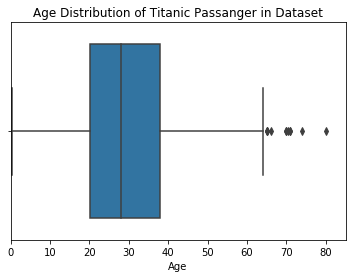

In [64]:
print 'Number of missing values: {}'.format(cleaned_titanic_df.Age.isnull().sum())

# draw histogram subplot for Age
g = sns.boxplot(cleaned_titanic_df[cleaned_titanic_df.Age.notnull()].Age)
g.axes.set_title('Age Distribution of Titanic Passanger in Dataset')
g.axes.set_xlim([0,85])

pd.DataFrame(cleaned_titanic_df.Age.describe())

As we've already known, there are 177 missing values in Age column which represent roughly 20% total records in the dataset. We can consider to remove these entries, and proceed with less data. However, that's might not be necessary since we won't be focusing our analysis in Age category alone. I decided to keep these missing values and made a note that they were there. 

Notice that for the 714 passengers in the dataset with available age values, the youngest passenger was 0.42 year old, and the oldest passenger was 80 years-old. Therefore, we can be sure that all age values are in a reasonable range.

Also notice that we have a positively skewed (mean=29.7, median=28), with interquartile range between 20.1 and 38. We can see from the boxplot that there are quite a few positive outliers, though I'm not going to do anything to them since they represent valid values. 

Now let see age distribution across gender.

count              mean                   std               min        \
Sex    female   male     female       male     female       male female  male   
Pclass                                                                          
1        85.0  101.0  34.611765  41.281386  13.612052  15.139570   2.00  0.92   
2        74.0   99.0  28.722973  30.740707  12.872702  14.793894   2.00  0.67   
3       102.0  253.0  21.750000  26.507589  12.729964  12.159514   0.75  0.42   

           25%          50%          75%           max        
Sex     female  male female  male female   male female  male  
Pclass                                                        
1       23.000  30.0   35.0  40.0  44.00  51.00   63.0  80.0  
2       22.250  23.0   28.0  30.0  36.00  36.75   57.0  70.0  
3       14.125  20.0   21.5  25.0  29.75  33.00   63.0  74.0

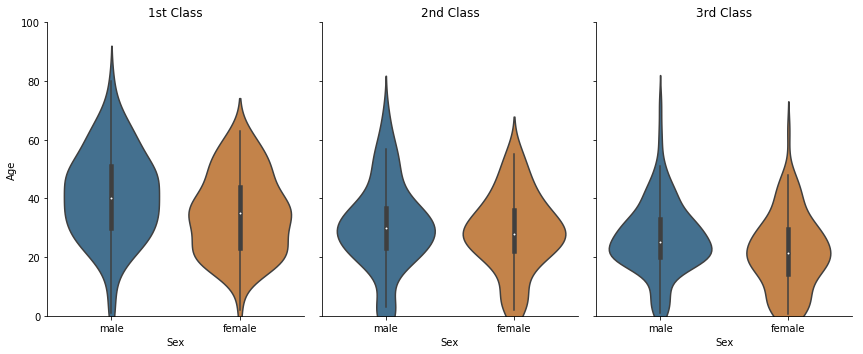

In [65]:
# graph - Age distribution by sex
g = sns.factorplot(x='Sex', y='Age', col='Pclass', data=cleaned_titanic_df[cleaned_titanic_df.Age.notnull()], 
                   saturation=.5, kind='violin', ci=None, size=5, aspect=.8)

g.set(ylim=(0,100))
# set titles
titles = ["1st Class", "2nd Class", "3rd Class"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

cleaned_titanic_df.groupby(['Pclass','Sex'])['Age'].describe().unstack()

We can see that average age for male passengers in first class(41.28) is higher than the average age of male passenger in second class (30.74), and the average age for the latter group is higher than the average age of male passenger in third class (26.51). The same pattern goes for female passenger average age for first (34.61), second (30.74), and third class passengers (21.75).

Notice that age distribution of each group is approximately normal. The long and skinny tail of the second and third class plots suggests positive outliers that we saw in blox plot earlier.

##### Talone

Number of missing values: 0


,count,percentage
Talone,,
False,354,39.7
True,537,60.3


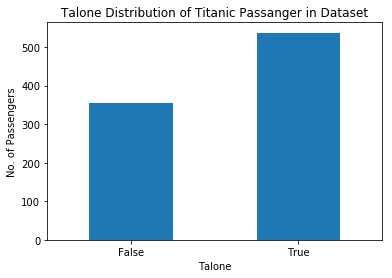

In [66]:
cleaned_titanic_bargraph('Talone')
cleaned_titanic_dist('Talone')

There's no incorrect and no missing values in Talone column. The numbers show that most passangers (60.3%) were traveling without any family member.

# Data Exploration and Visualization

Let's explore our data. First, we'll create a new Pandas DataFrame to store cleaned data.

In [67]:
# store data into new dataframe named data
data = cleaned_titanic_df

# the first few rows of cleaned dataset
data.head(n=10)

,Survived,Pclass,Sex,Age,Talone,AgeGroup
0,False,3,male,22.0,False,Adult
1,True,1,female,38.0,False,Adult
2,True,3,female,26.0,True,Adult
3,True,1,female,35.0,False,Adult
4,False,3,male,35.0,True,Adult
5,False,3,male,NaN,True,None
6,False,1,male,54.0,True,Adult
7,False,3,male,2.0,False,Child
8,True,3,female,27.0,False,Adult
9,True,2,female,14.0,False,Child


###### Data Dictionary of Cleaned Dataset

Variable      | Definition                                | Key
------------- | ------------------------------------------|------------------------------------------------
Survived      | Survival                                  | False = Not survived, True = Survived
Pclass        | Ticket Class                              | 1 = 1st, 2 = 2nd, 3 = 3rd
Sex           | Sex                                       |
Age           | Age in years                              |
Talone        | Traveling Alone                           | False = Travel with at least one family member, True = Travel Alone
AgeGroup      | Age Group                                 | Child = 17 or younger, Adult = older than 17

##### Data Limitation and Assumption

* The dataset only containts records from 891 passengers out of 2224 passengers and crew aboard the Titanic.
* We assume that the sampling method was simple random sampling.
* Some values are missing for Age and AgeGroup categories and will be ignored when dealing with these categories.

##### Overall Survival Rate

In [68]:
print "overall survival rate = {}%".format((data[['Survived']].unstack().mean()*100).round(2))

overall survival rate = 38.38%


This is going to be our reference rate when comparing whether in a particular circumstance the survival rate was higher or lower.

In [69]:
# calculate the survival count and survival rate
def survival_summary(dt, group):
    """
    Args:
        dt: data
        group: list of columns to use
    Returns:
        panda dataframe consist of survival count and percentage
    """
    
    count = dt.groupby(group).size().unstack()
    percentage = dt.groupby(group[:-1])[['Survived']].mean()

    return pd.DataFrame(data={'# survived=0':count[0], '# survived=1':count[1], 'survival rate': percentage['Survived']})

Let's start investigating.

## Q1: Did female passanger have a better chance of survival than male?

Now let's investigate the survival rate between male and female passengers and see whether female passengers were morelikely to survive than male passengers.

,# survived=0,# survived=1,survival rate
Sex,,,
female,81,233,0.742038
male,468,109,0.188908


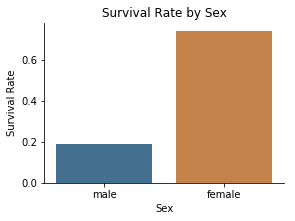

In [70]:
# graph - survival rate by sex
g = sns.factorplot(x="Sex", y="Survived", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Sex', 'Survival Rate')

# set titles
titles = ['Survival Rate by Sex']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by sex
survival_summary(data, ['Sex', 'Survived'])

We can see that roughly 74.204% female passengers in the dataset survived, but only 18.891% male passengers did. Let's see the number across socio-economic status. Tentatively, we can say that female passengers had a better chance of survival than overall passengers, while male passengers had a lower chance of survival than overall passengers, which means females were more likely to survive than male passengers.

Let's see the number across socio-economic status.

# survived=0  # survived=1  survival rate
Pclass Sex                                              
1      female             3            91       0.968085
       male              77            45       0.368852
2      female             6            70       0.921053
       male              91            17       0.157407
3      female            72            72       0.500000
       male             300            47       0.135447

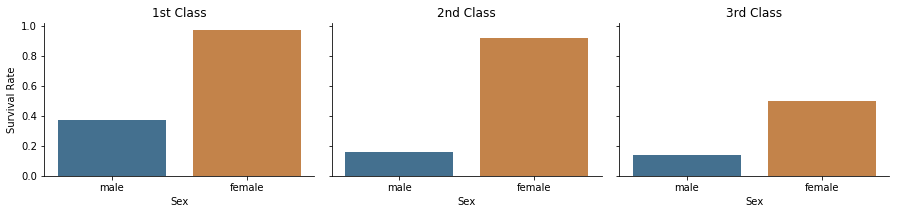

In [71]:
# graph - survival rate by sex across socio-economic status 
g = sns.factorplot(x="Sex", y="Survived", col="Pclass", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Sex', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by sex across socio-economic status
survival_summary(data, ['Pclass', 'Sex', 'Survived'])

Now we can see that even across socio-economic status, female passengers were more likely to survive compare to male passengers from the same socio-economic status. Let's dig deeper and see how the numbers do across socio-economic and travel type (whether a passenger was traveling with at least one family member or not).

# survived=0  # survived=1  survival rate
Pclass Talone Sex                                              
1      False  female             2            58       0.966667
              male              27            20       0.425532
       True   female             1            33       0.970588
              male              50            25       0.333333
2      False  female             3            41       0.931818
              male              26            10       0.277778
       True   female             3            29       0.906250
              male              65             7       0.097222
3      False  female            49            35       0.416667
              male              68            15       0.180723
       True   female            23            37       0.616667
              male             232            32       0.121212

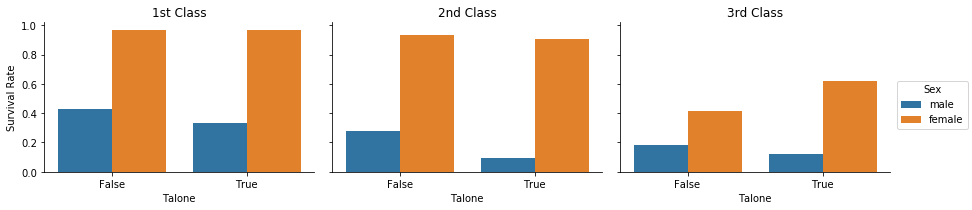

In [72]:
# graph - survival rate by Sex across socio-economic status and Talone
g = sns.factorplot(x = 'Talone', y='Survived', col='Pclass', hue='Sex'
                   , ci=None, data=data, kind='bar', size=3, aspect=1.4)

#set labels
(g.set_axis_labels('Talone', 'Survival Rate'))

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by Sex across socio-economic status and Talone
survival_summary(data, ['Pclass', 'Talone', 'Sex', 'Survived'])

It does also seem that female passengers were more likely to survived the sinking Titanic than male passengers from the same class and the same traveling status (whether traveling alone or not). Even the lowest survival rate for female passengers where Pclass = 3 and Talone = 0 with survival rate 41.7%, is just slightly lower than the highest survival rate for male passengers where Pclass = 1 and Talone =0 with survival rate 42.6%. 

Therefore, we conclude that a female passenger, regardless of socio-economic and traveling status, were more likely to survive than a male passangers.

## Q2: Did socio-economic status count as a factor in survival rate?

Now let's investigate the survival rate across socio-economic status and see passengers from which socio-economic status were more likely to survive.

,# survived=0,# survived=1,survival rate
Pclass,,,
1,80,136,0.629630
2,97,87,0.472826
3,372,119,0.242363


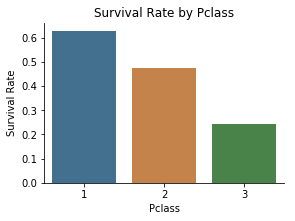

In [73]:
# graph - survival rate by socio-economic status
g = sns.factorplot(x="Pclass", y="Survived", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Pclass', 'Survival Rate')

# set titles
titles = ['Survival Rate by Pclass']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by socio-economic status
survival_summary(data, ['Pclass', 'Survived'])

Raw numbers and graph above suggest that in general, First Class passengers seems to had a higher chance of survival than Second Class passengers, and that Second Class passengers had a higher chance of survival than Third Class passengers.

First and second class passengers with survival rate of 62.96% and 47.28% respectively, had a better chance of survival than overall passengers. Third class passengers with survival rate of 24.36% had a lower chance of survival than overall passengers. These numbers suggest that socio-economic status was a factor that determine the chance of survival.

Let's see how socio-economic status do across gender.

# survived=0  # survived=1  survival rate
Sex    Pclass                                           
female 1                  3            91       0.968085
       2                  6            70       0.921053
       3                 72            72       0.500000
male   1                 77            45       0.368852
       2                 91            17       0.157407
       3                300            47       0.135447

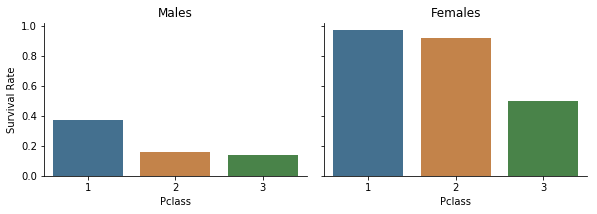

In [74]:
# graph - survival rate by socio-economic status across gender
g = sns.factorplot(x="Pclass", y="Survived", col="Sex", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Pclass', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['Males', 'Females']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by socio-economic status across gender
survival_summary(data, ['Sex', 'Pclass', 'Survived'])

It seems that among male passengers, socio-economic status played a role in a way that upper class passengers had a higher likelihood to survive (survival rate = 36.9%) than middle and lower class passengers. There seems to be only a slight difference between the survival rate of middle (15.7%) and lower (13.5%) class male passengers, that it could just be by chance. 

Among female passengers, socio-economic status played a role in determining the likelihood of survival in such a way that upper and middle class passengers had a higher chance of survival of 96.8% and 92.1% respectively, than lower class passengers (50.0%). There seems to be only a slight difference between upper and middle class female passangers survival rate, and it could also be just by chance.

Now let's dig deeper and see how it does across Talone.

# survived=0  # survived=1  survival rate
Sex    Talone Pclass                                           
female False  1                  2            58       0.966667
              2                  3            41       0.931818
              3                 49            35       0.416667
       True   1                  1            33       0.970588
              2                  3            29       0.906250
              3                 23            37       0.616667
male   False  1                 27            20       0.425532
              2                 26            10       0.277778
              3                 68            15       0.180723
       True   1                 50            25       0.333333
              2                 65             7       0.097222
              3                232            32       0.121212

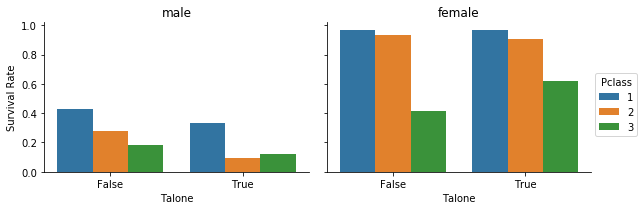

In [75]:
# graph - survival rate by socio-economic status across gender and Talone
g = sns.factorplot(x = 'Talone', y='Survived', col='Sex', hue='Pclass'
                   , ci=None, data=data, kind='bar', size=3, aspect=1.4)

#set labels
(g.set_axis_labels('Talone', 'Survival Rate'))

# set titles
titles = ['male', 'female']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by socio-economic status across gender and Talone
survival_summary(data, ['Sex', 'Talone', 'Pclass', 'Survived'])

Raw numbers and graph above amplify previous finding regarding socio-economic effect on survival rate of the passengers. No matter if they were traveling or not, female passengers in first and second class had a better chance of survival than those in third class. Also, no matter if they were traveling or not, male passengers in first class had a better chance of survival than those in second and third class. 

It is worth noting though, male passengers in second class who were traveling with at least one family members seems to have a better likelihood to survive than male passengers who were also traveling alone but from lower socio-economic status. This wasn't clear in the previous graph because the numbers for passengers traveling alone and not traveling alone was combined together.

## Q3: Did traveling alone (without family members: parents, spouse, children, or siblings) give a passanger a better chance at survival?

Now let's investigate the survival rate between those passengers who were traveling alone and those who were not, and see whether traveling alone gave a passenger a better chance of survival.

,# survived=0,# survived=1,survival rate
Talone,,,
False,175,179,0.505650
True,374,163,0.303538


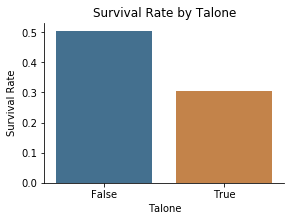

In [76]:
# graph - survival rate by Talone
g = sns.factorplot(x="Talone", y="Survived", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Talone', 'Survival Rate')

# set titles
titles = ['Survival Rate by Talone']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


# summary - survival rate by Talone
survival_summary(data, ['Talone', 'Survived'])

It seems that traveling alone didn't give a passanger a better chance at survival, in fact numbers and graph above suggest that the opposite is true. A passenger who traveled with at least one family member seems to had a better chance of survival at 50.565% than overall passengers, and a passenger who traveled alone (30.354%) had a lower chance of survival than overall passengers. Let's see if this pattern holds accross socio-economic statuses. 

# survived=0  # survived=1  survival rate
Pclass Talone                                           
1      False             29            78       0.728972
       True              51            58       0.532110
2      False             29            51       0.637500
       True              68            36       0.346154
3      False            117            50       0.299401
       True             255            69       0.212963

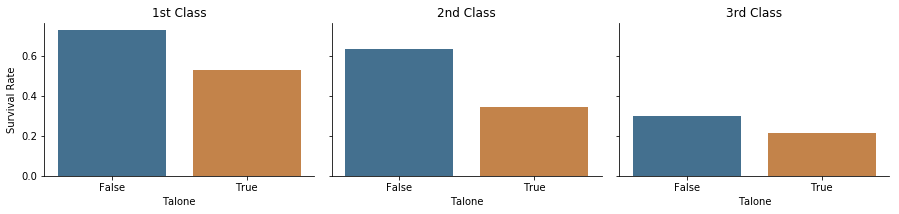

In [77]:
# graph - survival rate by Talone across socio-economic status
g = sns.factorplot(x="Talone", y="Survived", col="Pclass", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Talone', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by Talone across socio-economic status
survival_summary(data, ['Pclass', 'Talone', 'Survived'])

Indeed it does. In all three classes, passengers who traveled with at least one family member seem to had a higher survival rate than those who traveled alone. Now let's see how it appears accross gender. 

# survived=0  # survived=1  survival rate
Pclass Sex    Talone                                           
1      female False              2            58       0.966667
              True               1            33       0.970588
       male   False             27            20       0.425532
              True              50            25       0.333333
2      female False              3            41       0.931818
              True               3            29       0.906250
       male   False             26            10       0.277778
              True              65             7       0.097222
3      female False             49            35       0.416667
              True              23            37       0.616667
       male   False             68            15       0.180723
              True             232            32       0.121212

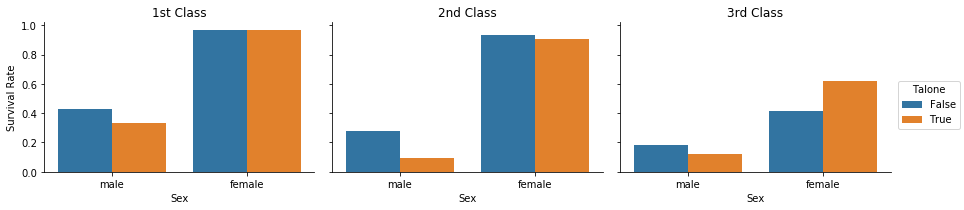

In [78]:
# graph - survival rate by Talone across socio-economic status and gender
g = sns.factorplot(x = 'Sex', y='Survived', col='Pclass', hue='Talone'
                   , ci=None, data=data, kind='bar', size=3, aspect=1.4)

#set labels
(g.set_axis_labels('Sex', 'Survival Rate'))

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by Talone across socio-economic status and gender
survival_summary(data, ['Pclass', 'Sex', 'Talone', 'Survived'])

This is interesting. Notice how the bar graph for male depicting that no matter which class a male passenger was in, his survival rate was higher if he was traveling with at least one family member. The largest survival rate difference between male passengers who were traveling with family member and those who were not, appears in 2nd class male passengers, with survival rate of 28.8% and 9.7% respectively.

Female passengers didn't quite follow the pattern we found in male passengers in regard to traveling alone, especiall for upper and middle class female passengers. Numbers show that no matter if they traveled with family or not, female passengers in first and second class seems to had the same likelihood to survive. But that is not the case for lower class female passengers, it seems that they had a better chance at survival if they were traveling without any family member.

Base on numbers and graphs, we can say that traveling alone did not give a passanger of Titanic a better chance at survival. The opposite seems to be true for male passengers regardless of his socio-economic status. Traveling alone or not didn't seem to affect female passangers chance of survival except for those in third class. A female passenger in third class had a better chance at survival when she traveled alone.  

## Q4: Did children (17 year-old or younger) have a better chance of survival?

Now let's investigate the survival rate between children and adults, and see whether children had a better chance of survival than adults.

,# survived=0,# survived=1,survival rate
AgeGroup,,,
Adult,355,220,0.382609
Child,69,70,0.503597


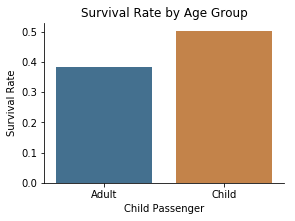

In [79]:
# graph - survival rate by ChildP
g = sns.factorplot(x="AgeGroup", y="Survived", data=data[data.Age.notnull()], 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Child Passenger', 'Survival Rate')

# set titles
titles = ['Survival Rate by Age Group']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


# summary - survival rate by ChildP
survival_summary(data[data.Age.notnull()], ['AgeGroup', 'Survived'])

It does seems that children were more likely to survive than adult passengers with survival rate of 53.98% and 38.10% respectively. But we can also see that children were only 20% of the total passengers with age values. 

Before we analyze the survival rate between age group across socio-economic status, let's see the composition of children and adult across socio-economic status.

AgeGroup,Adult,Child
Pclass,,
1,170,16
2,144,29
3,261,94


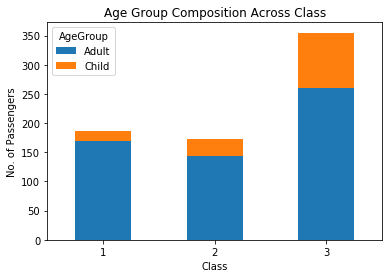

In [80]:
g = data[data.Age.notnull()].groupby(['Pclass', 'AgeGroup'])['Pclass'].count().unstack('AgeGroup').plot(kind='bar'
                                                                                                        , stacked=True, rot=0)

# set the title
g.axes.set_title("Age Group Composition Across Class")
    
# set the y label
g.axes.set_ylabel("No. of Passengers")
g.axes.set_xlabel("Class")

data.groupby(['Pclass', 'AgeGroup']).size().unstack()

Notice that children represent only a small percentage of passenger count in each class, roughly 9%, 16%, and 26% for first, second, and third class respectively. The lower count of child passengers could be problematic since a small size data can easily be skewed by adding additional data. We will leave this issue open for this project, and continue our exploration with the current dataset.

Let's see how socio-economic status affect the survival rate of adult and children passengers in our dataset.

# survived=0  # survived=1  survival rate
Pclass AgeGroup                                           
1      Adult               62           108       0.635294
       Child                2            14       0.875000
2      Adult               84            60       0.416667
       Child                6            23       0.793103
3      Adult              209            52       0.199234
       Child               61            33       0.351064

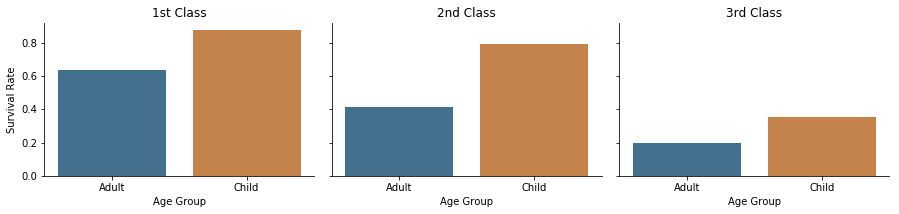

In [81]:
# graph - survival rate by ChildP across socio-economic status
g = sns.factorplot(x="AgeGroup", y="Survived", col="Pclass", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Age Group', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by ChildP across socio-economic status
survival_summary(data, ['Pclass', 'AgeGroup', 'Survived'])

Numbers and graphs above implify our previous finding. Across socio-economic status, children were more likely to survive compare to adult from the same socio-economic status.

# survived=0  # survived=1  survival rate
Pclass Sex    AgeGroup                                           
1      female Adult              2.0          72.0       0.972973
              Child              1.0          10.0       0.909091
       male   Adult             60.0          36.0       0.375000
              Child              1.0           4.0       0.800000
2      female Adult              6.0          54.0       0.900000
              Child              NaN          14.0       1.000000
       male   Adult             78.0           6.0       0.071429
              Child              6.0           9.0       0.600000
3      female Adult             34.0          25.0       0.423729
              Child             21.0          22.0       0.511628
       male   Adult            175.0          27.0       0.133663
              Child             40.0          11.0       0.215686

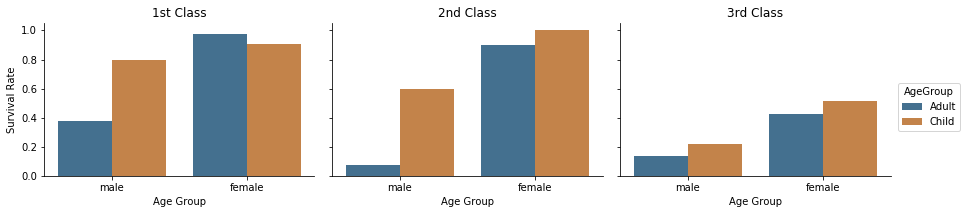

In [82]:
# graph - survival rate by ChildP across socio-economic status and Gender
g = sns.factorplot(x='Sex', y='Survived', col='Pclass', hue='AgeGroup', data=data[data.Age.notnull()], 
                   saturation=.5, kind='bar', ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels("Age Group", "Survival Rate")
plt.subplots_adjust(top=0.9)

# set titles
titles = ["1st Class", "2nd Class", "3rd Class"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
        
# summary - survival rate by ChildP across socio-economic status and Gender
survival_summary(data[data.Age.notnull()], ['Pclass', 'Sex', 'AgeGroup', 'Survived'])

Notice that the survival rate of girls in first class was lower than women from the same class, but it is worth to note that only one girl who did not survive from this class. Thus, the lower number might just be due to chance. Girls from second and third class however, seemed to had a better chance of survival than women from the same class.

Boys noticeably had a higher chance of survival than men in every socio-economic class. The highest difference betwen boys and men survival rate appeared to be in second class with boys survival rate at 60.00% while men survival rate at only 7.14%.

Furthermore, let's see age distribution of the survivors across socio-economic status and gender.

count             mean                   std              min  \
Survived       False True       False      True       False      True  False   
Pclass Sex                                                                     
1      female    3.0  82.0  25.666667  34.939024  24.006943  13.223014   2.0   
       male     61.0  40.0  44.581967  36.248000  14.457749  14.936744  18.0   
2      female    6.0  68.0  36.000000  28.080882  12.915107  12.764693  24.0   
       male     84.0  15.0  33.369048  16.022000  12.158125  19.547122  16.0   
3      female   55.0  47.0  23.818182  19.329787  12.833465  12.303246   2.0   
       male    215.0  38.0  27.255814  22.274211  12.135707  11.555786   1.0   

                        25%          50%         75%          max        
Survived       True   False  True  False True  False  True  False True   
Pclass Sex                                                               
1      female  14.00  13.50  23.25  25.0  35.0  37.5  44.00  50.0  63.0  
       male     0.92  33.00  27.00  45.5  36.0  56.0  48.00  71.0  80.0  
2      female   2.00  26.25  21.75  32.5  28.0  42.5  35.25  57.0  55.0  
       male     0.67  24.75   1.00  30.5   3.0  39.0  31.50  70.0  62.0  
3      female   0.75  15.25  13.50  22.0  19.0  31.0  26.50  48.0  63.0  
       male     0.42  20.00  16.50  25.0  25.0  34.0  29.75  74.0  45.0

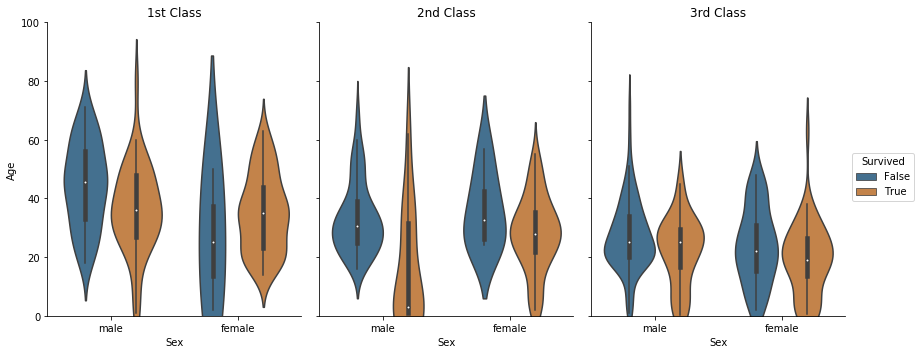

In [83]:
# graph - Age distribution by sex
g = sns.factorplot(x='Sex', y='Age', col='Pclass', hue='Survived', data=cleaned_titanic_df[cleaned_titanic_df.Age.notnull()], 
                   saturation=.5, kind='violin', ci=None, size=5, aspect=.8)

g.set(ylim=(0,100))
# set titles
titles = ["1st Class", "2nd Class", "3rd Class"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

cleaned_titanic_df.groupby(['Pclass','Sex','Survived'])['Age'].describe().unstack()


Though we cannot clearly distinguish between the two age groups (children and adults), the violin plots above give us an insightfull overview of the age distribution across socio-economic status, gender, and survival outcome.

We can see some interesting points in the plots, for example, we can see that there's a highly negatively skewed distribution of the age of male survivors in second class. This mean that we have more younger than older survivors in this particular group. Notice that there are only 15 passengers in the group and half of them are younger than 3, and 75% of them are younger than 31.50.

Notice that the the average age of male survivors in first class is lower (36.24) than male victims from the same class (44.58). This pattern can also be seen in second and third class, with average age 16.02 and 33.36 for survivors and victims in second class respectively, and 22.27 and 27.26 for survivors and victims in third class respectively.

The same pattern can also be found in female passengers across socio-economic status except in the first class. The average age of female survivors in first class (34.93) is actually higher than female victims in the same class (25.67). But there are only 3 female victims in this class, thus this irregularity might just be by chance. Female victims count in second class are also low, only 6 of them, but their avegerage age (36) is higher than female survivors from the same class (28.08). Female survivors in third class also have a lower age average (19.33) than female victims (23.83) in the same class.

# Statistical Testing

Base on our analysis during exploration process, we can draw a tentative conclusion that gender, socio-economic status, travel as family, and age group did affect the chance of survival of Titanic passengers. Now we need to test whether the survival outcome of the passenger was dependent on each of these characteristics.

### Gender

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and the gender of the Titanic passengers are independent of each other.

Alternative Hypothesis ($H_a$): survival outcome and the gender of the Titanic passengers are dependent.

##### Analysis Plan
For this analysis, the significant level is 0.01. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis

In [84]:
# observed values
obs = data.groupby(['Sex', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}) = {}".format(dof,chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=1) = 260.717020167
p-value = 1.19735706278e-58


##### Result
Since the p-value (0.00) is less than significant level (0.01), we reject the null hypothesis. Thus, we conclude that there is a relationship between gender and survival outcome of the Titanic passengers. 

### Socio-economic Status

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and the socio-economic status of the Titanic passengers are independent of each other.

Alternative Hypothesis ($H_a$): survival outcome and the socio-economic status of the Titanic passengers are dependent.

##### Analysis Plan
For this analysis, the significant level is 0.01. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis

In [85]:
# observed values
obs = data.groupby(['Pclass', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}, N={}) = {}".format(dof, 891, chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=2, N=891) = 102.888988757
p-value = 4.5492517113e-23


##### Result

Since the p-value (0.00) is less than significant level (0.01), we reject the null hypothesis. Thus, we conclude that there is a relationship between socio-economic status and survival outcome of the Titanic passengers. 

### Traveling Alone

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and traveling alone status of the Titanic passengers are independent of each other.

Alternative Hypothesis ($H_a$): survival outcome and traveling alone status of the Titanic passengers are dependent.

##### Analysis Plan
For this analysis, the significant level is 0.01. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis

In [86]:
# observed values
obs = data.groupby(['Talone', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}) = {}".format(dof,chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=1) = 36.0005144677
p-value = 1.97265438465e-09


##### Result
Since the p-value (0.00) is less than significant level (0.01), we reject the null hypothesis. Thus, we conclude that there is a relationship between traveling alone status and survival outcome of the Titanic passengers. 

### Age Group

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and age group (child or adult) status of the Titanic passengers are independent of each other

Alternative Hypothesis ($H_a$): survival outcome and age group (child or adult) status of the Titanic passengers are dependent

##### Analysis Plan
For this analysis, the significant level is 0.05. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis
Remember that we have missing values for Age, so we have to slice the data to consider only those with age values.

In [87]:
# observed values
obs = data[data.AgeGroup.notnull()].groupby(['AgeGroup', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}) = {}".format(dof,chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=1) = 6.30131105202
p-value = 0.0120648710317


##### Result
Since the p-value (0.01) is less than significant level (0.05), we reject the null hypothesis. Thus, we conclude that there is a relationship between age group status (whether a passenger was a child or an adult) and survival outcome of the Titanic passengers.

## Conclusion

Base on dataset analysis of the survival rate across gender, socio-economic status, travel companion, and age group, we come to a conclusion, though still tentative, that:

* Female passengers had a better chance of survival than male, with survival rate of 74.20% and 18.90% respectively.
* Socio-economic status was a factor in the survival rate of the Titanic passengers. Upper class passengers had the highest survival rate of 62.96%, followed by middle class passengers (survival rate = 47.28%), and lower class passengers (survival rate = 24.24%).
* Traveling alone did not give a passenger a better chance of survival. Suprisingly, the opposite was true. Those who were traveling with at least one family member, had a chance of survival at 50.57%, which is higher than the 38.36% survival rate of those who were traveling without any family member.
* Children (18 years old or younger) did have a better chance at survival (survival rate = 50.36%) than adult (older than 18) passengers (survival rate = 38.26%).

Furthermore, it appears that female passengers from upper or middle class socio-economic status had a high chance of survival (survival rate > 90%), and whether a passenger from this group was traveling alone or not, didn't seem to affect her chance of survival at all. Female passengers from lower class however, though still more likely to survive than male passengers in general, only had a 50% chance at survival, and traveling alone or not, seems to be a factor in their chance of survival. A third class female passenger who was traveling alone was more likely to survive (survival rate = 61.67%) than a female passenger from the same class who was traveling with at least one family member (survival rate = 41.67%).

Child passengers, regardless of their gender and socio-economic status, were also more likely to survive than adult passengers from the same gender and socio-economic status.

Male passengers overall were less likely to survive, though upper class men had the best chance at survival (survival rate = 36.89%) than other men from middle and lower class. The latter two groups survival rate were lower than overall male survival rate of 18.90%. Traveling alone or not appears to be a big deal in the male's chance of survival. Across socio-economic status those men who were traveling with at least one family member had a better chance of survival than those men from the same socio-economic status traveling alone. This makes upper class male who were traveling with at least one family member had the best chance at survival (survival rate = 42.55%) among men, and lower class male who were traveling alone had the worst chance at survival among them (survival rate = 18.07%).

Assuming the only chance for a passenger to survive was to get into a life boat, it appears that children and women were given priority to get into lifeboats. Adult male passengers, however, did not seem to get preference to a lifeboat and were left to fend for themselves, though those who traveled with a family member seems to had a better chance to get into a lifeboat. This could be because family tends to stick together, so when a woman or a child got preference to board a lifeboat, the husband of that woman or the father of that child would probably be allowed to follow aboard.

Chi-square tests were performed to determine the dependency of survival rate and each of the following characteristics: gender, socio-economic status, travel companion, and age group. These tests conclude:
* A chi-square test with significant level $\alpha = .01$ was performed and a relationship was found between gender and survival outcome of the Titanic passengers, $\chi^2(1, N=891)=260.72$, $p < .01$
* A chi-square test with significant level $\alpha = .01$ was performed and a relationship was found between socio-economic status and survival outcome of the Titanic passengers, $\chi^2(2, N=891)=102.89$, $p < .01$
* A chi-square test with significant level $\alpha = .01$ was performed and a relationship was found between traveling alone (without any family member) and survival outcome of the Titanic passengers, $\chi^2(1, N=891)=36.0$, $p < .01$
* A chi-square test with significant level $\alpha = .05$ was performed and a relationship was found between age group (children 18 years old or younger, and adult) and survival outcome of the Titanic passengers, $\chi^2(1, N=714)=6.30$, $p = .01$

## Limitation

* Dataset is only a sample - contains records of only 891 passengers out of 2224 passengers and crew aboard the Titanic, and contains 177 missing age values. Sample size and missing values can skew the result of analysis in this report.
* Data sampling method is unknown at this point. A biased selection sampling violate the assumption of simple random sampling used in chi-square tests and render previous results invalid.

## Future Research

* There are few other variables that are not considered in this report, such as cabin location, fare, and port of embarkation, which are worthy of detailed analysis in order to give us a better insight about the Titanic survivors and victims.
* Acquisition of complete datasest would bring more interesting discoveries, such as the comparison between passengers and crew, and would give true perspective about Titanic survivors and victims.
* Confirming the simple random sampling method will strengthen the conclusion of this report.

## References
* http://seaborn.pydata.org/tutorial/categorical.html
* http://stackoverflow.com/questions/24789671/change-the-title-of-factor-plot-in-seaborn
* http://www.secnetix.de/olli/Python/lambda_functions.hawk
* http://www.history.com/topics/titanic
* http://www.titanicfacts.net/titanic-survivors.html
* https://www.encyclopedia-titanica.org/titanic-survivors/
* http://www.stat.cmu.edu/~rnugent/PCMI2016/papers/ViolinPlots.pdf